In [19]:
import tensorflow as tf
import numpy as np
import pandas as pd
import six

from random import randint

from sklearn.model_selection import train_test_split

from skimage.transform import resize
from scipy.ndimage import morphology as mp

from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D, UpSampling2D, Conv2DTranspose, Concatenate, MaxPooling2D
from tensorflow.keras.layers import Activation, SpatialDropout2D
from tensorflow.keras.layers import Input, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import load_img

from tqdm import tqdm_notebook

from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.regularizers import l2
from keras.applications import VGG16

In [2]:
print("GPU Available" if len(tf.config.list_physical_devices('GPU')) > 0 else "GPU Not Detected")

GPU Not Detected


2024-03-23 13:32:47.948069: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-03-23 13:32:47.948097: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: marcello
2024-03-23 13:32:47.948102: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: marcello
2024-03-23 13:32:47.948199: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 550.54.14
2024-03-23 13:32:47.948214: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 550.54.14
2024-03-23 13:32:47.948218: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 550.54.14


In [3]:
from os import listdir

image_path = './data/images_cut/'
labels_path = './data/labels_cut/'

file_names = [filename for filename in listdir(image_path)]
train_files, val_files = train_test_split(file_names, test_size=0.3, random_state=42)

train_image_path = [image_path + file_name for file_name in train_files]
train_mask_path = [labels_path + file_name for file_name in train_files]

eval_image_path = [image_path + file_name for file_name in val_files]
eval_mask_path = [labels_path + file_name for file_name in val_files]

In [4]:
img_size_ori = 101
img_size_target = (224, 840)
img_w_target = 224
img_h_target = 224

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_w_target, img_h_target), mode='constant', preserve_range=True)
    
def downsample(img):
    return resize(img, (img_w_target, img_h_target), mode='constant', preserve_range=True)

In [48]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    
    def __init__(self, images,image_dir,labels,label_dir ,batch_size=16, dim=(224,224,3) ,shuffle=True):
        'Initialization'
        self.dim = dim
        self.images = images
        self.image_dir = image_dir
        self.labels = labels
        self.label_dir = label_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        list_IDs_temp = [k for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        batch_imgs = list()
        batch_labels = list()

        for i in list_IDs_temp:
            img = load_img(self.image_dir + self.images[i], target_size=self.dim, grayscale=False)
            img = img_to_array(img)/255.
            batch_imgs.append(img)
            label = load_img(self.label_dir + self.labels[i] ,target_size=self.dim, grayscale=False)
            label = img_to_array(label)[:,:,0]
            label = label != 0
            label = mp.binary_erosion(mp.binary_erosion(label))
            label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))
            label = np.expand_dims((label)*1 , axis=2)
            batch_labels.append(label)
            
        return np.array(batch_imgs, dtype = np.float32), np.array(batch_labels , dtype = np.float32 )

In [49]:
from os import listdir

train_imgs = listdir('./data/images_cut/')
train_masks = listdir('./data/labels_cut/')
train_imgs= sorted([ i for i in train_imgs ])
train_masks= sorted([ i for i in train_masks ])

print(len(train_imgs))
print(len(train_masks))

print(train_imgs[:3])
train_masks[:3]

train_df = pd.DataFrame({'image_path': train_image_path, 'mask_path': train_mask_path})

eval_df = pd.DataFrame({'image_path': eval_image_path, 'mask_path': eval_image_path})

val_img_dir =  './data/images_cut/'
val_mask_dir = './data/labels_cut/'
val_imgs = train_imgs[-25:]
val_masks = train_masks[-25:]
train_imgs = train_imgs[:-25]
train_masks = train_masks[:-25]

print(len(val_imgs))
print(len(val_masks))

100
100
['1008.png', '1009.png', '1016.png']
25
25


In [50]:
batch_size = 16
train_generator = DataGenerator(train_imgs,'./data/images_cut/',train_masks,'./data/labels_cut/',batch_size=batch_size, dim=(224,224,3) ,shuffle=True)
train_generator.__getitem__(1)
train_steps = train_generator.__len__()

/tmp/ipykernel_9389/515658363.py:45: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_erosion(mp.binary_erosion(label))
/tmp/ipykernel_9389/515658363.py:46: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


/tmp/ipykernel_9389/515658363.py:45: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_erosion(mp.binary_erosion(label))
/tmp/ipykernel_9389/515658363.py:46: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


(16, 224, 224, 3)


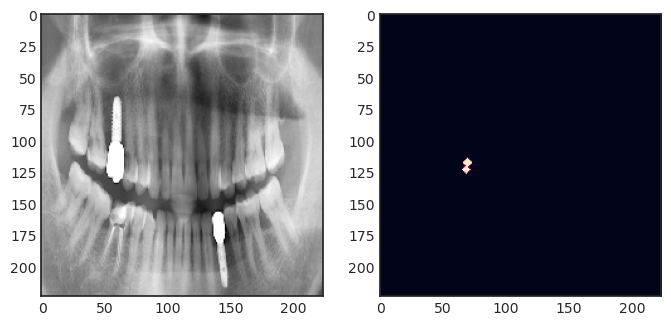

In [51]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import seaborn as sns
sns.set_style("white")

X,y = train_generator.__getitem__(1)
t = 10

print(X.shape)

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(X[t])
plt.subplot(122)
plt.imshow(np.reshape(y[t],(224,224)))

/tmp/ipykernel_9389/515658363.py:45: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_erosion(mp.binary_erosion(label))
/tmp/ipykernel_9389/515658363.py:46: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


(16, 224, 224, 3)


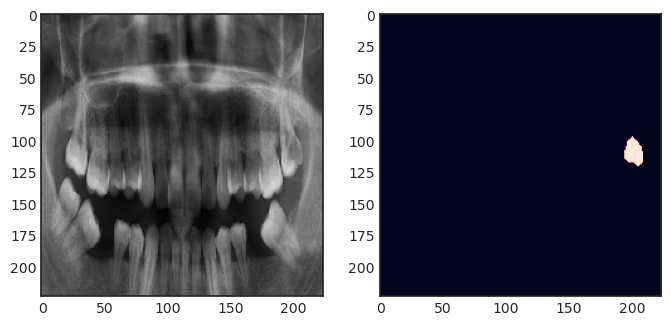

In [52]:
val_generator = DataGenerator(val_imgs,val_img_dir,val_masks,val_mask_dir,batch_size=batch_size, dim=(224,224,3) ,shuffle=True)
val_steps = val_generator.__len__()
val_images = val_generator.images
val_steps

X,y = val_generator.__getitem__(0)
t = 8

print(X.shape)

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(X[t])
plt.subplot(122)
plt.imshow(np.reshape(y[t],(224,224)))

# Unet Model

In [53]:
def handle_block_names(stage):
    conv_name = 'decoder_stage{}_conv'.format(stage)
    bn_name = 'decoder_stage{}_bn'.format(stage)
    relu_name = 'decoder_stage{}_relu'.format(stage)
    up_name = 'decoder_stage{}_upsample'.format(stage)
    return conv_name, bn_name, relu_name, up_name

def Upsample2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                     batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_block_names(stage)

        x = UpSampling2D(size=upsample_rate, name=up_name)(input_tensor)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'1')(x)

        if batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)

        x = Activation('relu', name=relu_name+'1')(x)

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'2')(x)

        if batchnorm:
            x = BatchNormalization(name=bn_name+'2')(x)

        x = Activation('relu', name=relu_name+'2')(x)

        return x
    return layer

In [54]:
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

In [55]:
def build_unet(backbone, classes, last_block_filters, skip_layers,
               n_upsample_blocks=4, upsample_rates=(2,2,2,2),
               block_type='upsampling', activation='sigmoid',
               **kwargs):

    input = backbone.input
    x = backbone.output

    print("Layer", getLayerIndexByName(backbone, 'block3_conv1'))

    skip_layers = ([getLayerIndexByName(backbone, l) if isinstance(l, str) else l
                    for l in skip_layers])
                    
    for i in range(n_upsample_blocks):
        # check if there is a skip connection
        if i < len(skip_layers):
            skip = backbone.layers[skip_layers[i]].output
        else:
            skip = None

        up_size = (upsample_rates[i], upsample_rates[i])
        filters = last_block_filters * 2**(n_upsample_blocks-(i+1))

        x = Upsample2D_block(filters, i, upsample_rate=up_size, skip=skip, **kwargs)(x)

    if classes < 2:
        activation = 'sigmoid'

    x = Conv2D(classes, (3,3), padding='same', name='final_conv')(x)
    x = Activation(activation, name=activation)(x)

    model = Model(input, x)

    return model

In [56]:
def UnetVgg(input_shape=(None, None, 3), classes=1, decoder_filters=16, decoder_block_type='upsampling',
                       encoder_weights=None, input_tensor=None, activation='sigmoid', **kwargs):

    backbone = VGG16(input_shape=input_shape,input_tensor=input_tensor,include_top=False)
    backbone.summary()

    skip_connections = list(['block1_conv2','block2_conv2','block3_conv3', 'block4_conv3', 'block5_conv3'])  # for resnet 34
    model = build_unet(backbone, classes, decoder_filters,
                       skip_connections, n_upsample_blocks=3, block_type=decoder_block_type,
                       activation=activation, **kwargs)
    model.name = 'u-resnet34'

    return model

In [84]:
def conv_block(inputs,filterCount):
    x = Conv2D(filterCount,3,padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(filterCount,3,padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

def decoder_block(inputs,skip_features,filter_count):
    
    x = Conv2DTranspose(filter_count, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, filter_count)
    return x

def unet_vgg16(input_shape):
    inputs = Input(input_shape)
    print(inputs.shape)
    vgg16 = VGG16(include_top=False,weights='imagenet',input_tensor = inputs)

    skip1 = vgg16.get_layer("block1_conv2").output
    print("First Skip connection", skip1)
    skip2 = vgg16.get_layer("block2_conv2").output
    skip3 = vgg16.get_layer("block3_conv3").output
    skip4 = vgg16.get_layer("block4_conv3").output
    
    center = vgg16.get_layer("block5_conv3").output
    
    d1 = decoder_block(center,skip4,512)
    d2 = decoder_block(d1,skip3,256)
    d3 = decoder_block(d2,skip2,128)
    d4 = decoder_block(d3,skip1,64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

In [85]:
# model = UnetVgg(input_shape=(img_w_target,img_h_target, 3))
model = unet_vgg16(input_shape=(224,224, 3))
model.summary()

(None, 224, 224, 3)
First Skip connection KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 64), dtype=tf.float32, name=None), name='block1_conv2/Relu:0', description="created by layer 'block1_conv2'")
Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                              

In [86]:
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    print("y_true_f", y_true_f)
    print("Score", 1. - score)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    print("y_true, y_pred", y_true, y_pred)
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [87]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics = ['accuracy'])
mc = ModelCheckpoint(mode='max', filepath='top.weights.h5', monitor='val_dice_coef',save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_dice_coef', patience=3, verbose=1)
callbacks = [mc, es]
model.metrics_names

[]

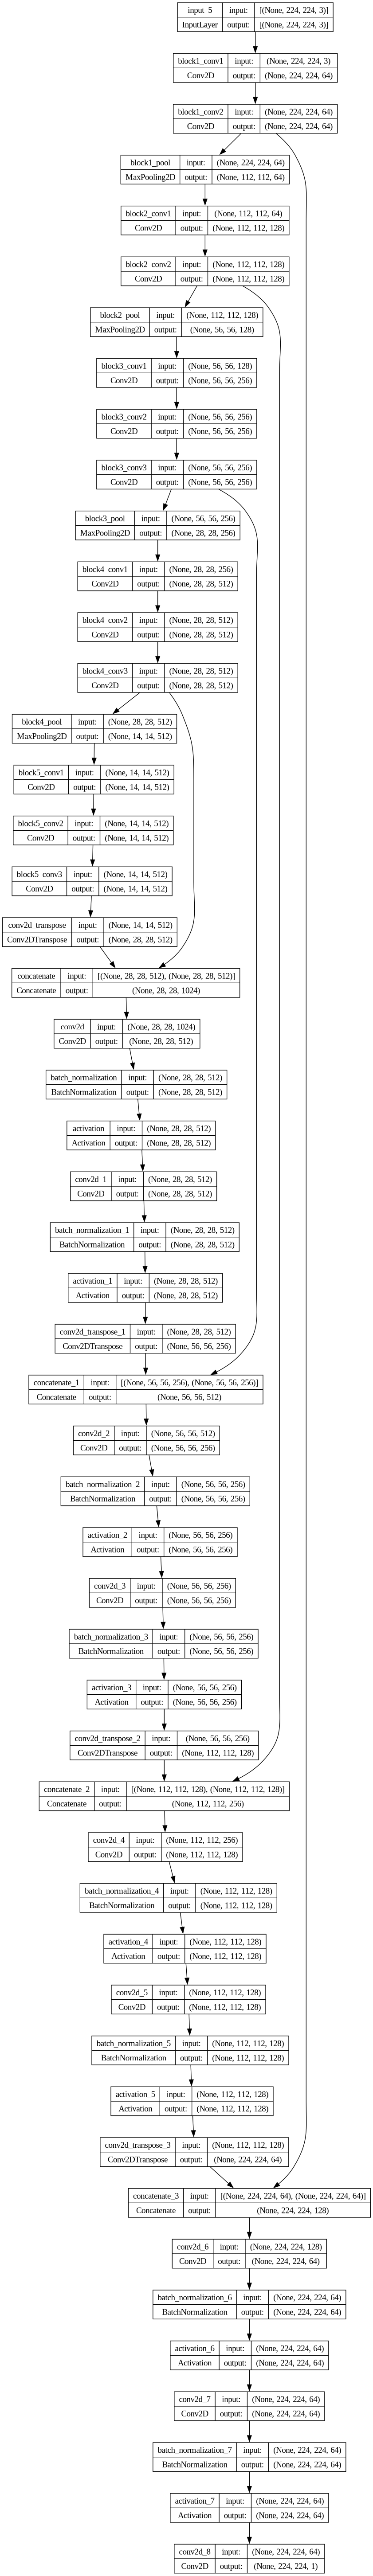

In [88]:
plot_model(model, show_shapes=True)

In [89]:
model_history = model.fit(train_generator, steps_per_epoch=train_steps,epochs=40,callbacks=callbacks,validation_data=val_generator,validation_steps=val_steps)

/tmp/ipykernel_9389/515658363.py:45: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_erosion(mp.binary_erosion(label))
/tmp/ipykernel_9389/515658363.py:46: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


Epoch 1/40
y_true, y_pred Tensor("IteratorGetNext:1", shape=(None, None, None, None), dtype=float32) Tensor("VGG16_U-Net/conv2d_8/Sigmoid:0", shape=(None, None, None, 1), dtype=float32)
y_true_f Tensor("bce_dice_loss/Reshape:0", shape=(None,), dtype=float32)
Score Tensor("bce_dice_loss/sub:0", shape=(), dtype=float32)
y_true, y_pred Tensor("IteratorGetNext:1", shape=(None, None, None, None), dtype=float32) Tensor("VGG16_U-Net/conv2d_8/Sigmoid:0", shape=(None, None, None, 1), dtype=float32)
y_true_f Tensor("bce_dice_loss/Reshape:0", shape=(None,), dtype=float32)
Score Tensor("bce_dice_loss/sub:0", shape=(), dtype=float32)
4/4 [==============================] - ETA: 0s - loss: 1.4111 - accuracy: 0.8881 y_true, y_pred Tensor("IteratorGetNext:1", shape=(None, None, None, None), dtype=float32) Tensor("VGG16_U-Net/conv2d_8/Sigmoid:0", shape=(None, None, None, 1), dtype=float32)
y_true_f Tensor("bce_dice_loss/Reshape:0", shape=(None,), dtype=float32)
Score Tensor("bce_dice_loss/sub:0", shape=

KeyboardInterrupt: 

In [ ]:
model_history.history.keys()

dict_keys(['loss', 'dice_coef', 'accuracy'])

In [ ]:
loss = model_history.history["loss"]

dice_coef = model_history.history["dice_coef"]

acc = model_history.history["accuracy"]

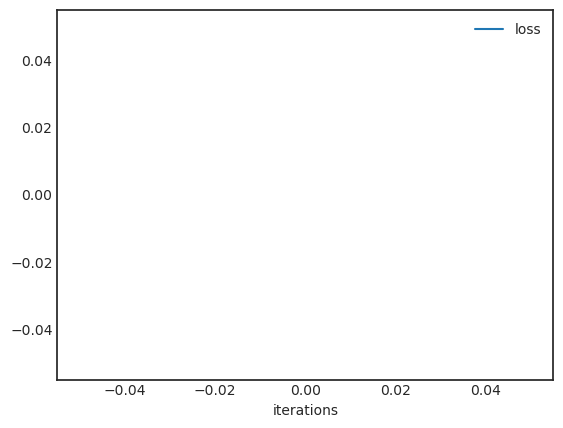

In [ ]:
plt.plot(loss,label = "loss")
plt.xlabel("iterations")
plt.legend()

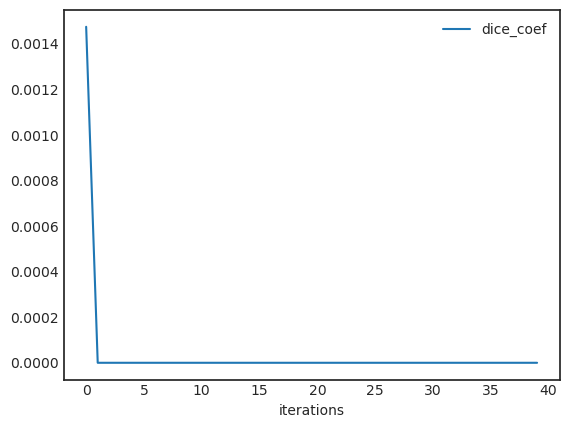

In [ ]:
plt.plot(dice_coef,label = "dice_coef")
# plt.plot(val_dice_coef,label  = "val dice_coef")
plt.xlabel("iterations")
# plt.ylabel("X axis label")
plt.legend()

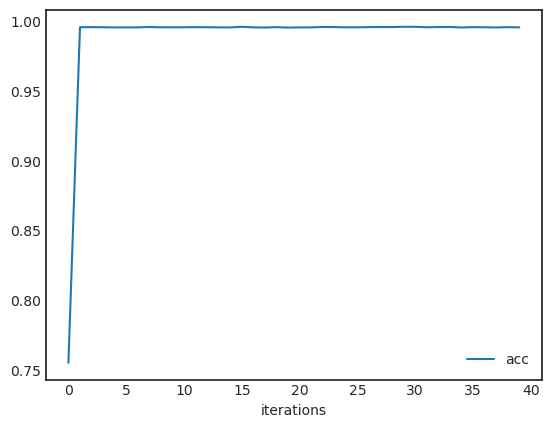

In [ ]:
plt.plot(acc,label = "acc")
# plt.plot(val_acc,label  = "val acc")
plt.xlabel("iterations")
# plt.ylabel("X axis label")
plt.legend()